# Refitting a PLOG into a TROE
1. First step compute the value of the kinetic constant of the PLOG across the ranges of pressure and temperature desired.
2. Compute first guess values for the TROE kinetic constant formalism, we will need the three arrhenius parameters both for the High pressure and low pressure limits and the four parameters of the TROE fitting formalism.
3. Run a global optimization to have reasonable values of the first guess. This should be fast something around 1s of wall time.
4. Run a gradient base optimizer to refine the solution (L-BFGS, adam, adabelief ...)
5. Finally evaluate the refitted constant by visual comparison, different plots are provided down below.

Keep in mind that providing already a reasonable first guess is crucial for the success of the refitting.

In [1]:
import os
import sys
from functools import partial

# Matplotlib and scipy
import matplotlib.pyplot as plt

# JAX stuff
import jax
jax.config.update("jax_enable_x64", True)
from jax import grad, value_and_grad, jacfwd, jacrev
import jax.numpy as jnp

# NLOPT python API
sys.path.append("/Users/tdinelli/NumericalLibraries/nlopt/nlopt-2.7.1-clang-18.1.7/lib/python3.12/site-packages")
import nlopt

# Internal modules
current_file_dir = os.getcwd()
module_path = os.path.abspath(os.path.join(current_file_dir, ".."))
sys.path.append(module_path)
from diffPLOG2TROE.falloff import compute_falloff, kinetic_constant_falloff
from diffPLOG2TROE.pressure_logarithmic import compute_plog, kinetic_constant_plog
from diffPLOG2TROE.refitter import rmse_loss_function, compute_pressure_limits, nlopt_loss

# Visualization

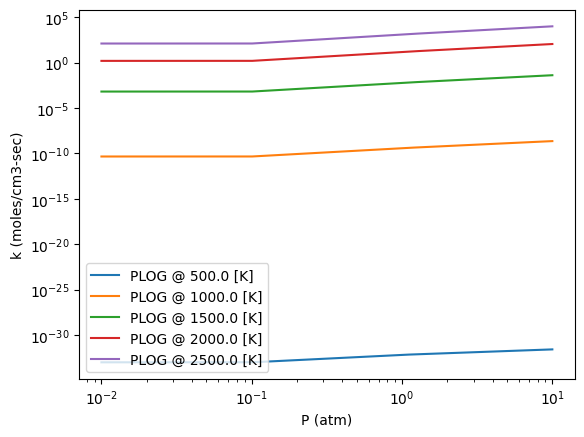

In [2]:
constant_plog = jnp.array([
    [1.00E-01, 7.23E+29, -5.32E+00, 110862.4],
    [1.00E+00, 3.50E+30, -5.22E+00, 111163.3],
    [1.00E+01, 1.98E+31, -5.16E+00, 111887.8],
    [1.00E+02, 2.69E+31, -4.92E+00, 112778.7],
], dtype=jnp.float64)

T = jnp.array([500, 1000, 1500, 2000, 2500], dtype=jnp.float64)  # Obv these are dummy values :)
P = jnp.logspace(-2, 1 , 300, dtype=jnp.float64)

for t in T:
    kc = compute_plog(constant_plog, jnp.array([t]), P)
    plt.plot(P, kc, "-", label=f"PLOG @ {t} [K]")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("P (atm)")
plt.ylabel("k (moles/cm3-sec)")
plt.legend()
plt.show()

In [9]:
T_range = jnp.logspace(2.5, 3.4, 10)
P_range = jnp.logspace(-1, 2, 10)

print(f"Temperature range -> {T_range[0]} - {T_range[-1]}")
print(f"Pressure range    -> {P_range[0]} - {P_range[-1]}")

k_plog = compute_plog(constant_plog, T_range, P_range)

pressure_limits_fg = compute_pressure_limits(constant_plog, T_range, P_range)

case = 0 # 0 All, 1 TROE only, KIN only

if case == 0:
    # ALL TROE
    fg = jnp.array([
        jnp.log(pressure_limits_fg[3]), pressure_limits_fg[4], pressure_limits_fg[5]/1.987, # HPL
        jnp.log(pressure_limits_fg[0]), pressure_limits_fg[1], pressure_limits_fg[2]/1.987, # LPL
        10.0,    100.0,   1e+30, 1e+30
        # 1.61256E+04,    6.66209E+04,   5.00000E+29, 5.00000E+29
    ], dtype=jnp.float64)
    data = (T_range, P_range, k_plog)
    bounds = [
        (jnp.log(pressure_limits_fg[3]) - 5, jnp.log(pressure_limits_fg[3]) + 5),
        (pressure_limits_fg[4] - 3, pressure_limits_fg[4] + 3),
        (pressure_limits_fg[5] / 1.987 - 20000, pressure_limits_fg[5] / 1.987 + 20000),
        (jnp.log(pressure_limits_fg[0]) - 5, jnp.log(pressure_limits_fg[0]) + 5),
        (pressure_limits_fg[1] - 3, pressure_limits_fg[1] + 3),
        (pressure_limits_fg[2] / 1.987 - 20000, pressure_limits_fg[2] / 1.987 + 20000),
        (1e-2, 1e5),
        (1e-5, 1e5),
        (1, 1e30),
        (1, 1e30),
    ]
elif case == 1:
    # TROE params only
    fg = jnp.array([
        10.0,    100.0,   1e+30, 1e+30
    ], dtype=jnp.float64)
    additional = jnp.array([
        jnp.log(pressure_limits_fg[3]), pressure_limits_fg[4], pressure_limits_fg[5]/1.987,
        jnp.log(pressure_limits_fg[0]), pressure_limits_fg[1], pressure_limits_fg[2]/1.987,
    ], dtype=jnp.float64)
    data = (T_range, P_range, k_plog, additional)
    bounds = [
        (1e-5, 1e5),
        (1e-5, 1e5),
        (1, 1e30),
        (1, 1e30),
    ]
elif case == 2:
    # Kinetic params only
    fg = jnp.array([
        jnp.log(pressure_limits_fg[3]), pressure_limits_fg[4], pressure_limits_fg[5]/1.987,
        jnp.log(pressure_limits_fg[0]), pressure_limits_fg[1], pressure_limits_fg[2]/1.987,
    ], dtype=jnp.float64)
    additional = jnp.array([9.27612E+04,    5.99365E+03,   6.46973E+27, 2.96509E+29], dtype=jnp.float64)
    data = (T_range, P_range, k_plog, additional)
    bounds = [
        (jnp.log(pressure_limits_fg[3]) - 5, jnp.log(pressure_limits_fg[3]) + 5),
        (pressure_limits_fg[4] - 3, pressure_limits_fg[4] + 3),
        (pressure_limits_fg[5] / 1.987 - 20000, pressure_limits_fg[5] / 1.987 + 20000),
        (jnp.log(pressure_limits_fg[0]) - 5, jnp.log(pressure_limits_fg[0]) + 5),
        (pressure_limits_fg[1] - 3, pressure_limits_fg[1] + 3),
        (pressure_limits_fg[2] / 1.987 - 20000, pressure_limits_fg[2] / 1.987 + 20000),
    ]

Temperature range -> 316.22776601683796 - 2511.88643150958
Pressure range    -> 0.1 - 100.0


In [10]:
%%time
print(fg)
print(rmse_loss_function(fg, data))
iter_count = [0]
lbs = [float(i[0]) for i in bounds]
ubs = [float(i[1]) for i in bounds]

# opt = nlopt.opt(nlopt.GN_CRS2_LM, len(fg))
# opt = nlopt.opt(nlopt.GN_AGS, len(fg))
# opt = nlopt.opt(nlopt.GD_STOGO, len(fg))
# opt = nlopt.opt(nlopt.GN_DIRECT_L, len(fg))
# opt = nlopt.opt(nlopt.GN_ESCH, len(fg))
opt = nlopt.opt(nlopt.GN_ISRES, len(fg))
# opt = nlopt.opt(nlopt.LD_MMA, len(fg))

opt.set_lower_bounds(lbs)
opt.set_upper_bounds(ubs)
opt.set_xtol_rel(1e-10) 
opt.set_ftol_rel(1e-10)
opt.set_maxeval(10000000)
# opt.set_maxtime(600)

opt.set_min_objective(partial(nlopt_loss, data=data, iteration_count=iter_count))
final_params = opt.optimize(fg)
minf = opt.last_optimum_value()

print("result code = ", opt.last_optimize_result())

[ 7.23696685e+01 -5.91999865e+00  5.67582778e+04  6.87531969e+01
 -6.31999874e+00  5.57938591e+04  1.00000000e+01  1.00000000e+02
  1.00000000e+30  1.00000000e+30]
9.999999757362989
Loss = 6.0253258623E+03
Loss = 8.2962145914E+04
Loss = 1.6658339983E+02
Loss = 1.0000000000E+01
Loss = 3.0962781420E+02
Loss = 1.0000000000E+01
Loss = 1.2680566989E+01
Loss = 1.0000000000E+01
Loss = 9.9999999700E+00
Loss = 2.2702865037E+14
Loss = 4.5058836863E+17
Loss = 1.1297081714E+16
Loss = 1.0000000000E+01
Loss = 1.5497880944E+04
Loss = 9.9742093707E+00
Loss = 9.9291220432E+00
Loss = 9.9999999968E+00
Loss = 1.0000000000E+01
Loss = 9.9906414624E+00
Loss = 9.9964362808E+00
Loss = 9.9999777038E+00
Loss = 1.0000000000E+01
Loss = 9.7665431619E+00
Loss = 9.9999881158E+00
Loss = 2.9902494665E+05
Loss = 9.9601252089E+00
Loss = 9.9999999950E+00
Loss = 9.9999991752E+00
Loss = 9.9999528476E+00
Loss = 3.4978860334E+01
Loss = 9.9999755737E+00
Loss = 5.2352626790E+01
Loss = 9.9999999601E+00
Loss = 1.0000000000E+01
Lo

In [11]:
if case == 0:
    refitted_troe = (
        jnp.array([
            [jnp.exp(final_params[0]), final_params[1], final_params[2]*1.987, 0.000],  # HPL, the fourth term is dummy
            [jnp.exp(final_params[3]), final_params[4], final_params[5]*1.987, 0.000],  # LPL, the fourth term is dummy
            [final_params[6], final_params[7], final_params[8], final_params[9]],  # TROE parameters
        ], dtype=jnp.float64),
        1, # Lindemann -> 0, TROE -> 1, SRI -> 2
    )
if case == 1:
    refitted_troe = (
        jnp.array([
            [jnp.exp(additional[0]), additional[1], additional[2]*1.987, 0.000],  # HPL, the fourth term is dummy
            [jnp.exp(additional[3]), additional[4], additional[5]*1.987, 0.000],  # LPL, the fourth term is dummy
            [final_params[0], final_params[1], final_params[2], final_params[3]],  # TROE parameters
        ], dtype=jnp.float64),
        1, # Lindemann -> 0, TROE -> 1, SRI -> 2
    )
if case == 2:
    refitted_troe = (
        jnp.array([
            [jnp.exp(final_params[0]), final_params[1], final_params[2]*1.987, 0.000],  # HPL, the fourth term is dummy
            [jnp.exp(final_params[3]), final_params[4], final_params[5]*1.987, 0.000],  # LPL, the fourth term is dummy
            [additional[0], additional[1], additional[2], additional[3]],  # TROE parameters
        ], dtype=jnp.float64),
        1, # Lindemann -> 0, TROE -> 1, SRI -> 2
    )
k_refitted = compute_falloff(refitted_troe, T_range, P_range)

print(refitted_troe)

(Array([[ 1.81248957e+29, -3.90956102e+00,  1.13113875e+05,
         0.00000000e+00],
       [ 5.88915776e+31, -4.00068685e+00,  1.10139896e+05,
         0.00000000e+00],
       [ 2.94976437e-01,  1.60641115e+02,  8.05992156e+29,
         2.42171385e+29]], dtype=float64), 1)


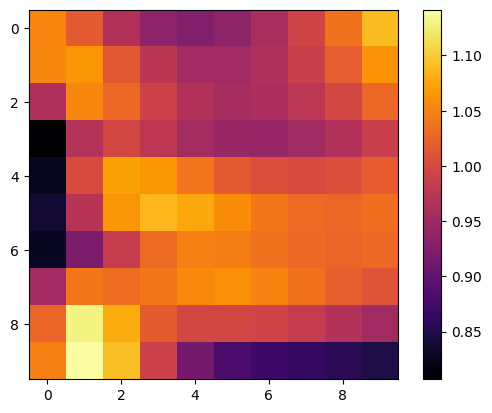

In [12]:
ratio = k_refitted / k_plog
fig, ax = plt.subplots()

c = ax.imshow(ratio, cmap='inferno', interpolation='nearest')
fig.colorbar(c, ax=ax)

plt.show()

In [13]:
print(k_plog[:, -1])
print(k_refitted[:, -1])

[  133.23464155   286.76949842   617.23245747  1328.50916382
  2637.64606475  5236.83008924 10397.29694975 20297.50763532
 39624.60803004 77354.79595544]
[  145.23925119   304.56326064   634.87811028  1313.07498122
  2687.07449994  5418.88081263 10704.73730799 20531.32686727
 37750.46367017 65486.55743046]
